<a href="https://colab.research.google.com/github/Astridgiraldo/RH/blob/main/A)LIMPIEZA_Y_TRANSF_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn
!pip install sklearn.prepocessing

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
import sqlite3 as sql
#import sklearn.prepocessing
import joblib
from ipywidgets import interact   ## analisis interactivo
#from sklearn import neighborns ## basado en contenido un solo


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## conectar la base de datos

conn = sql.connect ("/content/drive/MyDrive/analitica3/marketing /db_movies")
cur=conn.cursor()

In [5]:
# consultar bases de datos que se pueden consultar por medio de sql
cur.execute("Select name from sqlite_master where type='table'")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('usuarios_fil',),
 ('movies_fil',)]

In [15]:
#Se asigna el valor de a la BD de ratings
a = "SELECT * FROM ratings"

In [16]:
#Se le asigna el valor b a la BD de movies
b = "SELECT * FROM movies"

In [7]:
#Se consulta la BD de ratings
pd.read_sql_query(a, conn).head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


'SELECT * FROM ratings'

In [17]:
#Se le asignan nombres a las consultas de SQL para llamarlas con sentencias de Pandas
ratings = pd.read_sql_query(a, conn)
movies = pd.read_sql_query(b, conn)

In [31]:
### verificar cuantas calificaciones hay por peliculas
conteo_ratings=pd.read_sql_query("""SELECT rating, COUNT(*)AS count
              FROM  ratings
              GROUP BY rating""", conn)
conteo_ratings


,rating,count
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550
5,3.0,20047
6,3.5,13136
7,4.0,26818
8,4.5,8551
9,5.0,13211


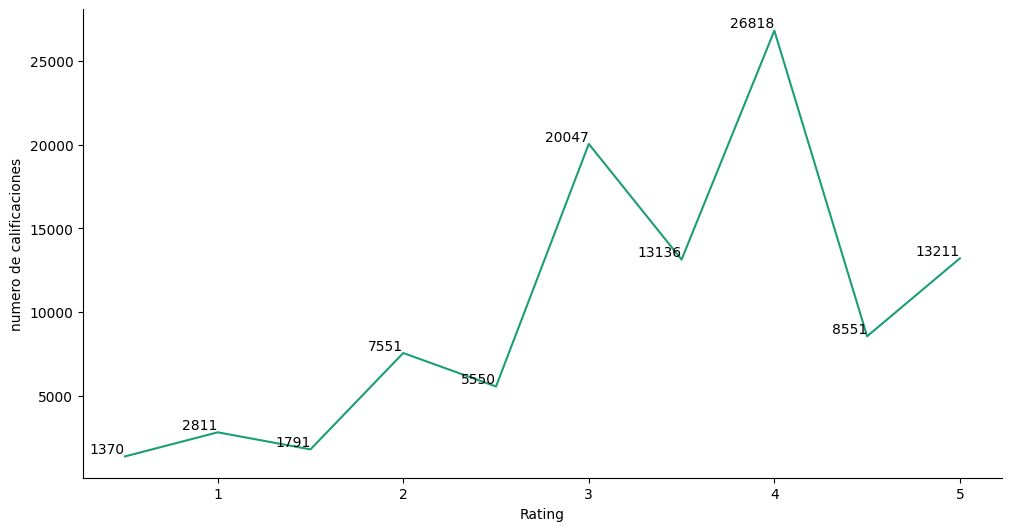

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rating']
  ys = series['count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])
  for x, y in zip(xs, ys):
        plt.text(x, y, str(y), ha='right', va='bottom')


fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = conteo_ratings.sort_values('rating', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rating')
_ = plt.ylabel('numero de calificaciones')

### Analisando la siguiete grafica, se evidecia que 26818 peliculas obtuvieros una calificacion de 4

In [ ]:
#Se consulta la BD de movies
pd.read_sql_query(b, conn)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
#Se consulta si hay películas duplicadas
movies['movieId'].duplicated().sum()

0

In [ ]:
#Se consulta si hay usuarios duplicados
ratings['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: userId, Length: 610, dtype: int64

**La mayoría de usuarios en la BD de ratings están duplicados pero no significa que haya errores debido a que cada registro corresponde a una película que vio el usuario por lo que no hay necesidad de imputar**

In [ ]:
#Se crea una nueva tabla que filtra cuántas películas vio cada usuario

tabla_existente = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' AND name='usuarios_sel'", conn)

# Si la tabla usuarios_sel no existe, entonces la creamos
if tabla_existente.empty:
    consulta_sql = """
        CREATE TABLE usuarios_sel AS
        SELECT userId, COUNT(*) AS n_id
        FROM ratings
        GROUP BY userId
        ORDER BY n_id ASC
    """

    pd.read_sql_query(consulta_sql, conn)
else:
    print("La tabla usuarios_sel ya existe en la base de datos.")

La tabla usuarios_sel ya existe en la base de datos.


In [ ]:
#Se consulta la tabla del total de películas que ha visto cada usuario entre 10 y 600
pd.read_sql_query("SELECT * FROM usuarios_sel", conn)

,userId,n_id
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
573,219,528
574,28,570
575,91,575
576,555,578


In [ ]:
#Se crea una nueva tabla que filtra cuántas veces ha sido vista cada película
#discriminando sólo a las que se han visto mínimo 50 veces

# Eliminamos la tabla si existe
cur.execute("DROP TABLE IF EXISTS movies_sel")

# Creamos la tabla movies_sel
cur.execute("""
    CREATE TABLE movies_sel AS
    SELECT movieId, COUNT(*) AS n_movie
    FROM ratings
    GROUP BY movieId
    ORDER BY n_movie DESC
""")

In [ ]:
pd.read_sql_query("SELECT * FROM movies_sel", conn)

,movieId,n_movie
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
9719,96,1
9720,83,1
9721,77,1
9722,55,1


In [ ]:
#Se guardan las tablas filtradas en variables para consultarlas con sentencias de Pandas

userviews = pd.read_sql_query("SELECT * FROM usuarios_sel", conn)
movieviews = pd.read_sql_query("SELECT * FROM movies_sel", conn)

In [ ]:
#Se hace un resumen estadístico de la distribución de la cantidad de películas que ha visto cada usuario

userviews['n_id'].describe()

count    578.000000
mean     115.401384
std      119.758038
min       20.000000
25%       34.250000
50%       64.500000
75%      146.250000
max      600.000000
Name: n_id, dtype: float64

In [ ]:
fig  = px.histogram(userviews, x= 'n_id', title= 'Hist frecuencia de número de visualizaciones por usuario')
fig.show()

In [ ]:
#Se hace un resumen estadístico de la distribución de la cantidad de veces que ha sido vista una película

movieviews['n_movie'].describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: n_movie, dtype: float64

In [ ]:
fig  = px.histogram(movieviews, x= 'n_movie', title= 'Hist frecuencia de número de visualizaciones por película')
fig.show()

**Filtros**

In [ ]:
#Se crea una nueva tabla que filtra cuántas películas vio cada usuario
#discriminando sólo a los que han visto entre 20 y 500

tabla_existente = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' AND name='usuarios_fil'", conn)

# Si la tabla usuarios_fil no existe, entonces la creamos
if tabla_existente.empty:
    consulta_sql_1 = """
        CREATE TABLE usuarios_fil AS
        SELECT userId, COUNT(*) AS n_id
        FROM ratings
        GROUP BY userId
        HAVING n_id >= 20 AND n_id <= 500
        ORDER BY n_id ASC
    """

    pd.read_sql_query(consulta_sql_1, conn)
else:
    print("La tabla usuarios_fil ya existe en la base de datos.")

La tabla usuarios_fil ya existe en la base de datos.


In [ ]:
#Se consulta la tabla del total de películas que ha visto cada usuario entre 20 y 500
pd.read_sql_query("SELECT * FROM usuarios_fil", conn)

,userId,n_id
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
562,509,467
563,368,469
564,381,474
565,57,476


In [ ]:
#Se crea una nueva tabla que filtra cuántas veces ha sido vista cada película
#discriminando sólo a las que se han visto mínimo 20 veces

# Eliminamos la tabla si existe
cur.execute("DROP TABLE IF EXISTS movies_fil")

# Creamos la tabla movies_fil
cur.execute("""
    CREATE TABLE movies_fil AS
    SELECT movieId, COUNT(*) AS n_movie
    FROM ratings
    GROUP BY movieId
    HAVING n_movie >= 20
    ORDER BY n_movie DESC
""")


In [ ]:

pd.read_sql_query("SELECT * FROM movies_fil", conn)

,movieId,n_movie
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
1292,319,20
1293,308,20
1294,175,20
1295,69,20


In [ ]:
#Se guardan las tablas filtradas en variables para consultarlas con sentencias de Pandas

userviews_fil = pd.read_sql_query("SELECT * FROM usuarios_fil", conn)
movieviews_fil = pd.read_sql_query("SELECT * FROM movies_fil", conn)

In [ ]:
#Se hace un resumen estadístico de la distribución de la cantidad de películas que ha visto cada usuario (filtro)

userviews_fil['n_id'].describe()

count    567.000000
mean     107.199295
std      105.154761
min       20.000000
25%       34.000000
50%       63.000000
75%      139.500000
max      500.000000
Name: n_id, dtype: float64

In [ ]:
#Se hace un resumen estadístico de la distribución de la cantidad de visualizaciones de cada película (filtro)

movieviews_fil['n_movie'].describe()

count    1297.000000
mean       52.350039
std        40.207459
min        20.000000
25%        27.000000
50%        39.000000
75%        61.000000
max       329.000000
Name: n_movie, dtype: float64